# Setup

In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import (false_positive_rate, false_negative_rate, true_positive_rate, true_negative_rate, selection_rate)
from IPython.display import display

In [4]:
# read in data
df_train = pd.read_csv("data/train.csv")
df_songs = pd.read_csv("data/songs.csv")
df_artists = pd.read_csv("data/artists.csv")

df_artists.rename(columns={"gender": "artist_gender"}, inplace=True)
df_artists.rename(columns={"country": "artist_country"}, inplace=True)

In [5]:
# merge data together
seeds = [85, 25, 121, 61, 73, 37, 97, 49, 109, 13]
popularity_tresholds = [100, 1000]
popularity_func = lambda x: 'high' if x >= popularity_tresholds[1] else 'medium' if x >= popularity_tresholds[0] else 'low'

df_info = df_train.merge(df_songs, on="song_id", how="left")
df_info = df_info.merge(df_artists, on="artist_name", how="left")
artist_listeners = df_info.groupby('artist_name')['msno'].nunique()
artist_popularity = artist_listeners.apply(popularity_func)
df_info['artist_listeners'] = df_info['artist_name'].map(artist_listeners)
df_info['artist_popularity'] = df_info['artist_name'].map(artist_popularity)

merged_dfs = []

for seed in seeds:
    predictions = pd.read_csv(f"data/predictions/final/final_seed{seed}.csv")
    df_merged = predictions.merge(df_info, on=["song_id", "msno"], how="left")
    df_merged['prediction'] = df_merged['probability'] >= 0.5
    merged_dfs.append(df_merged)

# Profiling

<BarContainer object of 6 artists>

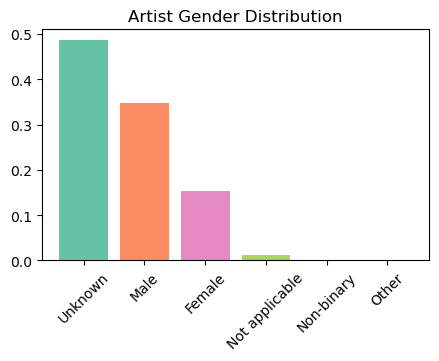

In [6]:
# Artist Gender Distribution
gender_counts = df_artists['artist_gender'].fillna('Unknown').value_counts(normalize=True, dropna=False)
colors = plt.cm.Set2(np.linspace(0, 1, len(gender_counts)))

plt.figure(figsize=(5, 3))
plt.xticks(rotation=45)
plt.title('Artist Gender Distribution')
plt.bar(gender_counts.index, gender_counts.values, color=colors)

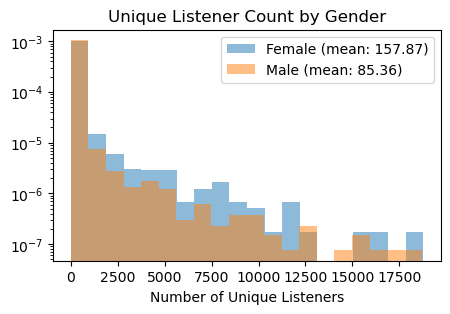

In [7]:
# Number of unique listeners by gender
male_listeners = df_artists[df_artists['artist_gender'] == 'Male']['artist_name'].map(artist_listeners)
female_listeners = df_artists[df_artists['artist_gender'] == 'Female']['artist_name'].map(artist_listeners)

# get means
male_listeners_mean = male_listeners.mean()
female_listeners_mean = female_listeners.mean()

plt.figure(figsize=(5, 3))
plt.hist(female_listeners, bins=20, density=True, alpha=0.5, label=f'Female (mean: {female_listeners_mean:.2f})')
plt.hist(male_listeners, bins=20, density=True, alpha=0.5, label=f'Male (mean: {male_listeners_mean:.2f})')

plt.title('Unique Listener Count by Gender')
plt.xlabel('Number of Unique Listeners')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
# Proportion of plays by gender
analysis_genders = ['Male', 'Female']
df_info['artist_gender'].value_counts(normalize=True, dropna=False)

artist_gender
Male              0.365736
NaN               0.322883
Female            0.306893
Not applicable    0.002845
Non-binary        0.001594
Other             0.000050
Name: proportion, dtype: float64

In [9]:
# Average plays by gender
artist_play_counts = (
    df_info[df_info['artist_gender'].isin(analysis_genders)]
    .groupby(['artist_name', 'artist_gender'])
    .size()
    .reset_index(name='play_count')
)
artist_play_counts.groupby('artist_gender')['play_count'].mean()

artist_gender
Female    363.882353
Male      191.442032
Name: play_count, dtype: float64

In [10]:
df_info['target'].value_counts(normalize=True)

target
1    0.503517
0    0.496483
Name: proportion, dtype: float64

In [11]:
# Get proportion of positive targets (target==1) that are Male and Female
positive_targets = df_info[df_info['target'] == 1]
male_positive_proportion = (positive_targets['artist_gender'] == 'Male').mean()
female_positive_proportion = (positive_targets['artist_gender'] == 'Female').mean()

print("Proportion of positive target that is Male:", male_positive_proportion)
print("Proportion of positive target that is Female:", female_positive_proportion)


Proportion of positive target that is Male: 0.37413693219506733
Proportion of positive target that is Female: 0.3044933366642833


# Overall Performance

In [12]:
performance_metrics = {
    "Accuracy": accuracy_score,
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=np.nan),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=np.nan),
    "FNR": false_negative_rate,
    "FPR": false_positive_rate,
    "TPR": true_positive_rate,
    "TNR": true_negative_rate,
    "Selection Rate": selection_rate,
}

def get_performance_metrics(y_true, y_pred):
    return {name: func(y_true, y_pred) for name, func in performance_metrics.items()}

In [13]:
# Get performance metrics
rows = []

for df in merged_dfs:
    y_pred = df["prediction"]
    y_true = df["target"]
    row = get_performance_metrics(y_true, y_pred)
    rows.append(row)

df_performance_metrics = pd.DataFrame(rows)
df_performance_metrics

,Accuracy,Precision,Recall,FNR,FPR,TPR,TNR,Selection Rate
0,0.765222,0.775116,0.754591,0.245409,0.223906,0.754591,0.776094,0.492231
1,0.766371,0.776813,0.754797,0.245203,0.221792,0.754797,0.778208,0.491290
2,0.765735,0.776692,0.753244,0.246756,0.221490,0.753244,0.778510,0.490355
3,0.765873,0.776507,0.753952,0.246048,0.221934,0.753952,0.778066,0.490933
4,0.765625,0.776225,0.753759,0.246241,0.222238,0.753759,0.777762,0.490985
5,0.766197,0.777379,0.753323,0.246677,0.220637,0.753323,0.779363,0.489973
6,0.765919,0.776709,0.753725,0.246275,0.221610,0.753725,0.778390,0.490658
7,0.766405,0.776757,0.754989,0.245011,0.221920,0.754989,0.778080,0.491450
8,0.766265,0.777363,0.753540,0.246460,0.220720,0.753540,0.779280,0.490124
9,0.767076,0.777753,0.755104,0.244896,0.220680,0.755104,0.779320,0.490895


Ok - metrics are really stable across the 10 runs. Therefore, we will just do the analysis on one of the runs for simplicity and to keep runtimes low, since not much is gained from looking at the 10 runs separately

In [14]:
# Recommendation-level performance
df_merged = merged_dfs[0]
get_performance_metrics(df_merged["target"], df_merged["prediction"])

{'Accuracy': 0.7652216424176081,
 'Precision': 0.7751161599005084,
 'Recall': 0.754590970938681,
 'FNR': 0.24540902906131898,
 'FPR': 0.22390600860460383,
 'TPR': 0.754590970938681,
 'TNR': 0.7760939913953961,
 'Selection Rate': 0.4922307362573907}

In [15]:
# Artist-level performance - need to aggregate metrics

# Filter out artists with less than 3 recommendations - too few for reliable performance metrics
artist_name_counts = df_merged['artist_name'].value_counts()
artist_names_with_more_than_3 = artist_name_counts[artist_name_counts > 3].index
df_sample = df_merged[df_merged['artist_name'].isin(artist_names_with_more_than_3)]

artist_genders = dict(zip(df_artists['artist_name'], df_artists['artist_gender']))
agg_artist_metrics = []

# compute metrics for each artist separately
for artist_name in df_sample['artist_name'].unique():
    artist_gender = artist_genders[artist_name]
    listeners_for_artist = artist_listeners[artist_name]
    popularity_for_artist = artist_popularity[artist_name]

    df_artist = df_sample[df_sample['artist_name'] == artist_name]
    artist_metrics = get_performance_metrics(df_artist['target'], df_artist['prediction'])

    artist_metrics['artist_name'] = artist_name
    artist_metrics['artist_gender'] = artist_gender
    artist_metrics['artist_popularity'] = popularity_for_artist

    agg_artist_metrics.append(artist_metrics)

df_artist_metrics = pd.DataFrame(agg_artist_metrics)
df_artist_metrics

,Accuracy,Precision,Recall,FNR,FPR,TPR,TNR,Selection Rate,artist_name,artist_gender,artist_popularity
0,0.764088,0.761341,0.753906,0.246094,0.226168,0.753906,0.773832,0.484241,戴愛玲 (Ailing Tai),Female,high
1,0.757039,0.771123,0.741007,0.258993,0.226455,0.741007,0.773545,0.487487,任賢齊 (Richie Jen),Male,high
2,0.866667,0.666667,0.285714,0.714286,0.026316,0.285714,0.973684,0.066667,ANOHNI,Female,medium
3,0.766038,0.762769,0.727163,0.272837,0.199645,0.727163,0.800355,0.446981,王力宏 (Leehom Wang),Male,high
4,0.773045,0.789092,0.841990,0.158010,0.327192,0.841990,0.672808,0.632201,林俊傑 (JJ Lin),Male,high
...,...,...,...,...,...,...,...,...,...,...,...
9927,0.833333,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,Young Doe,Male,low
9928,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.166667,Lee Ryan,Male,low
9929,0.500000,0.000000,NaN,0.000000,0.500000,0.000000,0.500000,0.500000,กัน นภัทร| โตโน่ ภาคิน |ริท เรืองฤทธิ์,Male,low
9930,0.600000,1.000000,0.333333,0.666667,0.000000,0.333333,1.000000,0.200000,이광석,NaN,low


In [16]:
# get average metrics
df_artist_metrics[list(performance_metrics.keys())].mean()

Accuracy          0.770334
Precision         0.741157
Recall            0.565964
FNR               0.402965
FPR               0.140891
TPR               0.525449
TNR               0.844409
Selection Rate    0.310884
dtype: float64

# Performance by Gender

In [17]:
# aggregate metrics by gender
df_artist_metrics_filtered = df_artist_metrics[df_artist_metrics['artist_gender'].isin(analysis_genders)]
artist_metrics_gender_average = df_artist_metrics_filtered.groupby('artist_gender')[list(performance_metrics.keys())].mean()
artist_metrics_gender_average

,Accuracy,Precision,Recall,FNR,FPR,TPR,TNR,Selection Rate
artist_gender,,,,,,,,
Female,0.764499,0.738568,0.571788,0.403268,0.142028,0.538480,0.848749,0.315195
Male,0.774274,0.742317,0.565895,0.400058,0.138204,0.521511,0.848440,0.307019


In [18]:
def get_fairness_metrics(df_metrics_1, df_metrics_2):
    fnr_1 = df_metrics_1['FNR']
    fnr_2 = df_metrics_2['FNR']
    fpr_1 = df_metrics_1['FPR']
    fpr_2 = df_metrics_2['FPR']
    tpr_1 = df_metrics_1['TPR']
    tpr_2 = df_metrics_2['TPR']
    tnr_1 = df_metrics_1['TNR']
    tnr_2 = df_metrics_2['TNR']
    sr_1 = df_metrics_1['Selection Rate']
    sr_2 = df_metrics_2['Selection Rate']

    tpr = min(tpr_1, tpr_2) / max(tpr_1, tpr_2)
    tnr = min(tnr_1, tnr_2) / max(tnr_1, tnr_2)

    fnr_difference = np.abs(fnr_1 - fnr_2)
    fpr_difference = np.abs(fpr_1 - fpr_2)
    dpr = min(sr_1, sr_2) / max(sr_1, sr_2)
    eor = min(tpr, tnr)
    sr_difference = np.abs(sr_1 - sr_2)

    return {
        'FNR Difference': fnr_difference,
        'FPR Difference': fpr_difference,
        'Demographic Parity Ratio': dpr,
        'Equalized Odds Ratio': eor,
        'Selection Rate Difference': sr_difference
    }


In [19]:
male_metrics = artist_metrics_gender_average.loc['Male']
female_metrics = artist_metrics_gender_average.loc['Female']
get_fairness_metrics(male_metrics, female_metrics)

{'FNR Difference': 0.003209674757172154,
 'FPR Difference': 0.003823420719984233,
 'Demographic Parity Ratio': 0.9740616436507086,
 'Equalized Odds Ratio': 0.9684867184395122,
 'Selection Rate Difference': 0.008175630191683714}

# Popularity as a Confounder

In [34]:
artist_metrics_mean = df_artist_metrics_filtered.groupby(['artist_gender', 'artist_popularity'])[list(performance_metrics.keys())].mean()
artist_metrics_mean = artist_metrics_mean.reindex(
    ['Male', 'Female'],
    level='artist_gender'
)
artist_metrics_mean = artist_metrics_mean.reindex(
    ['low', 'medium', 'high'],
    level='artist_popularity'
)
display(artist_metrics_mean)

Accuracy  Precision    Recall       FNR  \
artist_gender artist_popularity                                            
Male          low                0.777345   0.737084  0.531184  0.415259   
              medium             0.768447   0.746019  0.608454  0.391546   
              high               0.763977   0.771806  0.731599  0.268401   
Female        low                0.763672   0.728890  0.529439  0.426957   
              medium             0.766866   0.745269  0.602265  0.397735   
              high               0.763209   0.769690  0.733183  0.266817   

                                      FPR       TPR       TNR  Selection Rate  
artist_gender artist_popularity                                                
Male          low                0.123043  0.470502  0.857504        0.276821  
              medium             0.156855  0.608454  0.843145        0.345458  
              high               0.229193  0.731599  0.770807        0.483119  
Female        low                0.124625  0.480379  0.860703        0.280302  
              medium             0.151794  0.602265  0.848206        0.336354  
              high               0.226373  0.733183  0.773627        0.479916

In [70]:
# get fairness metrics by popularity
fairness_metrics_by_popularity = []

for pop in ['low', 'medium', 'high']:
    male_metrics = artist_metrics_mean.loc[('Male', pop)]
    female_metrics = artist_metrics_mean.loc[('Female', pop)]
    metrics = get_fairness_metrics(male_metrics, female_metrics)
    metrics['Popularity'] = pop
    fairness_metrics_by_popularity.append(metrics)

fairness_metrics_df = pd.DataFrame(fairness_metrics_by_popularity).set_index('Popularity')
display(fairness_metrics_df)


,FNR Difference,FPR Difference,Demographic Parity Ratio,Equalized Odds Ratio,Selection Rate Difference
Popularity,,,,,
low,0.011698,0.001583,0.987581,0.979440,0.003481
medium,0.006189,0.005061,0.973646,0.989829,0.009104
high,0.001584,0.002820,0.993369,0.996355,0.003204


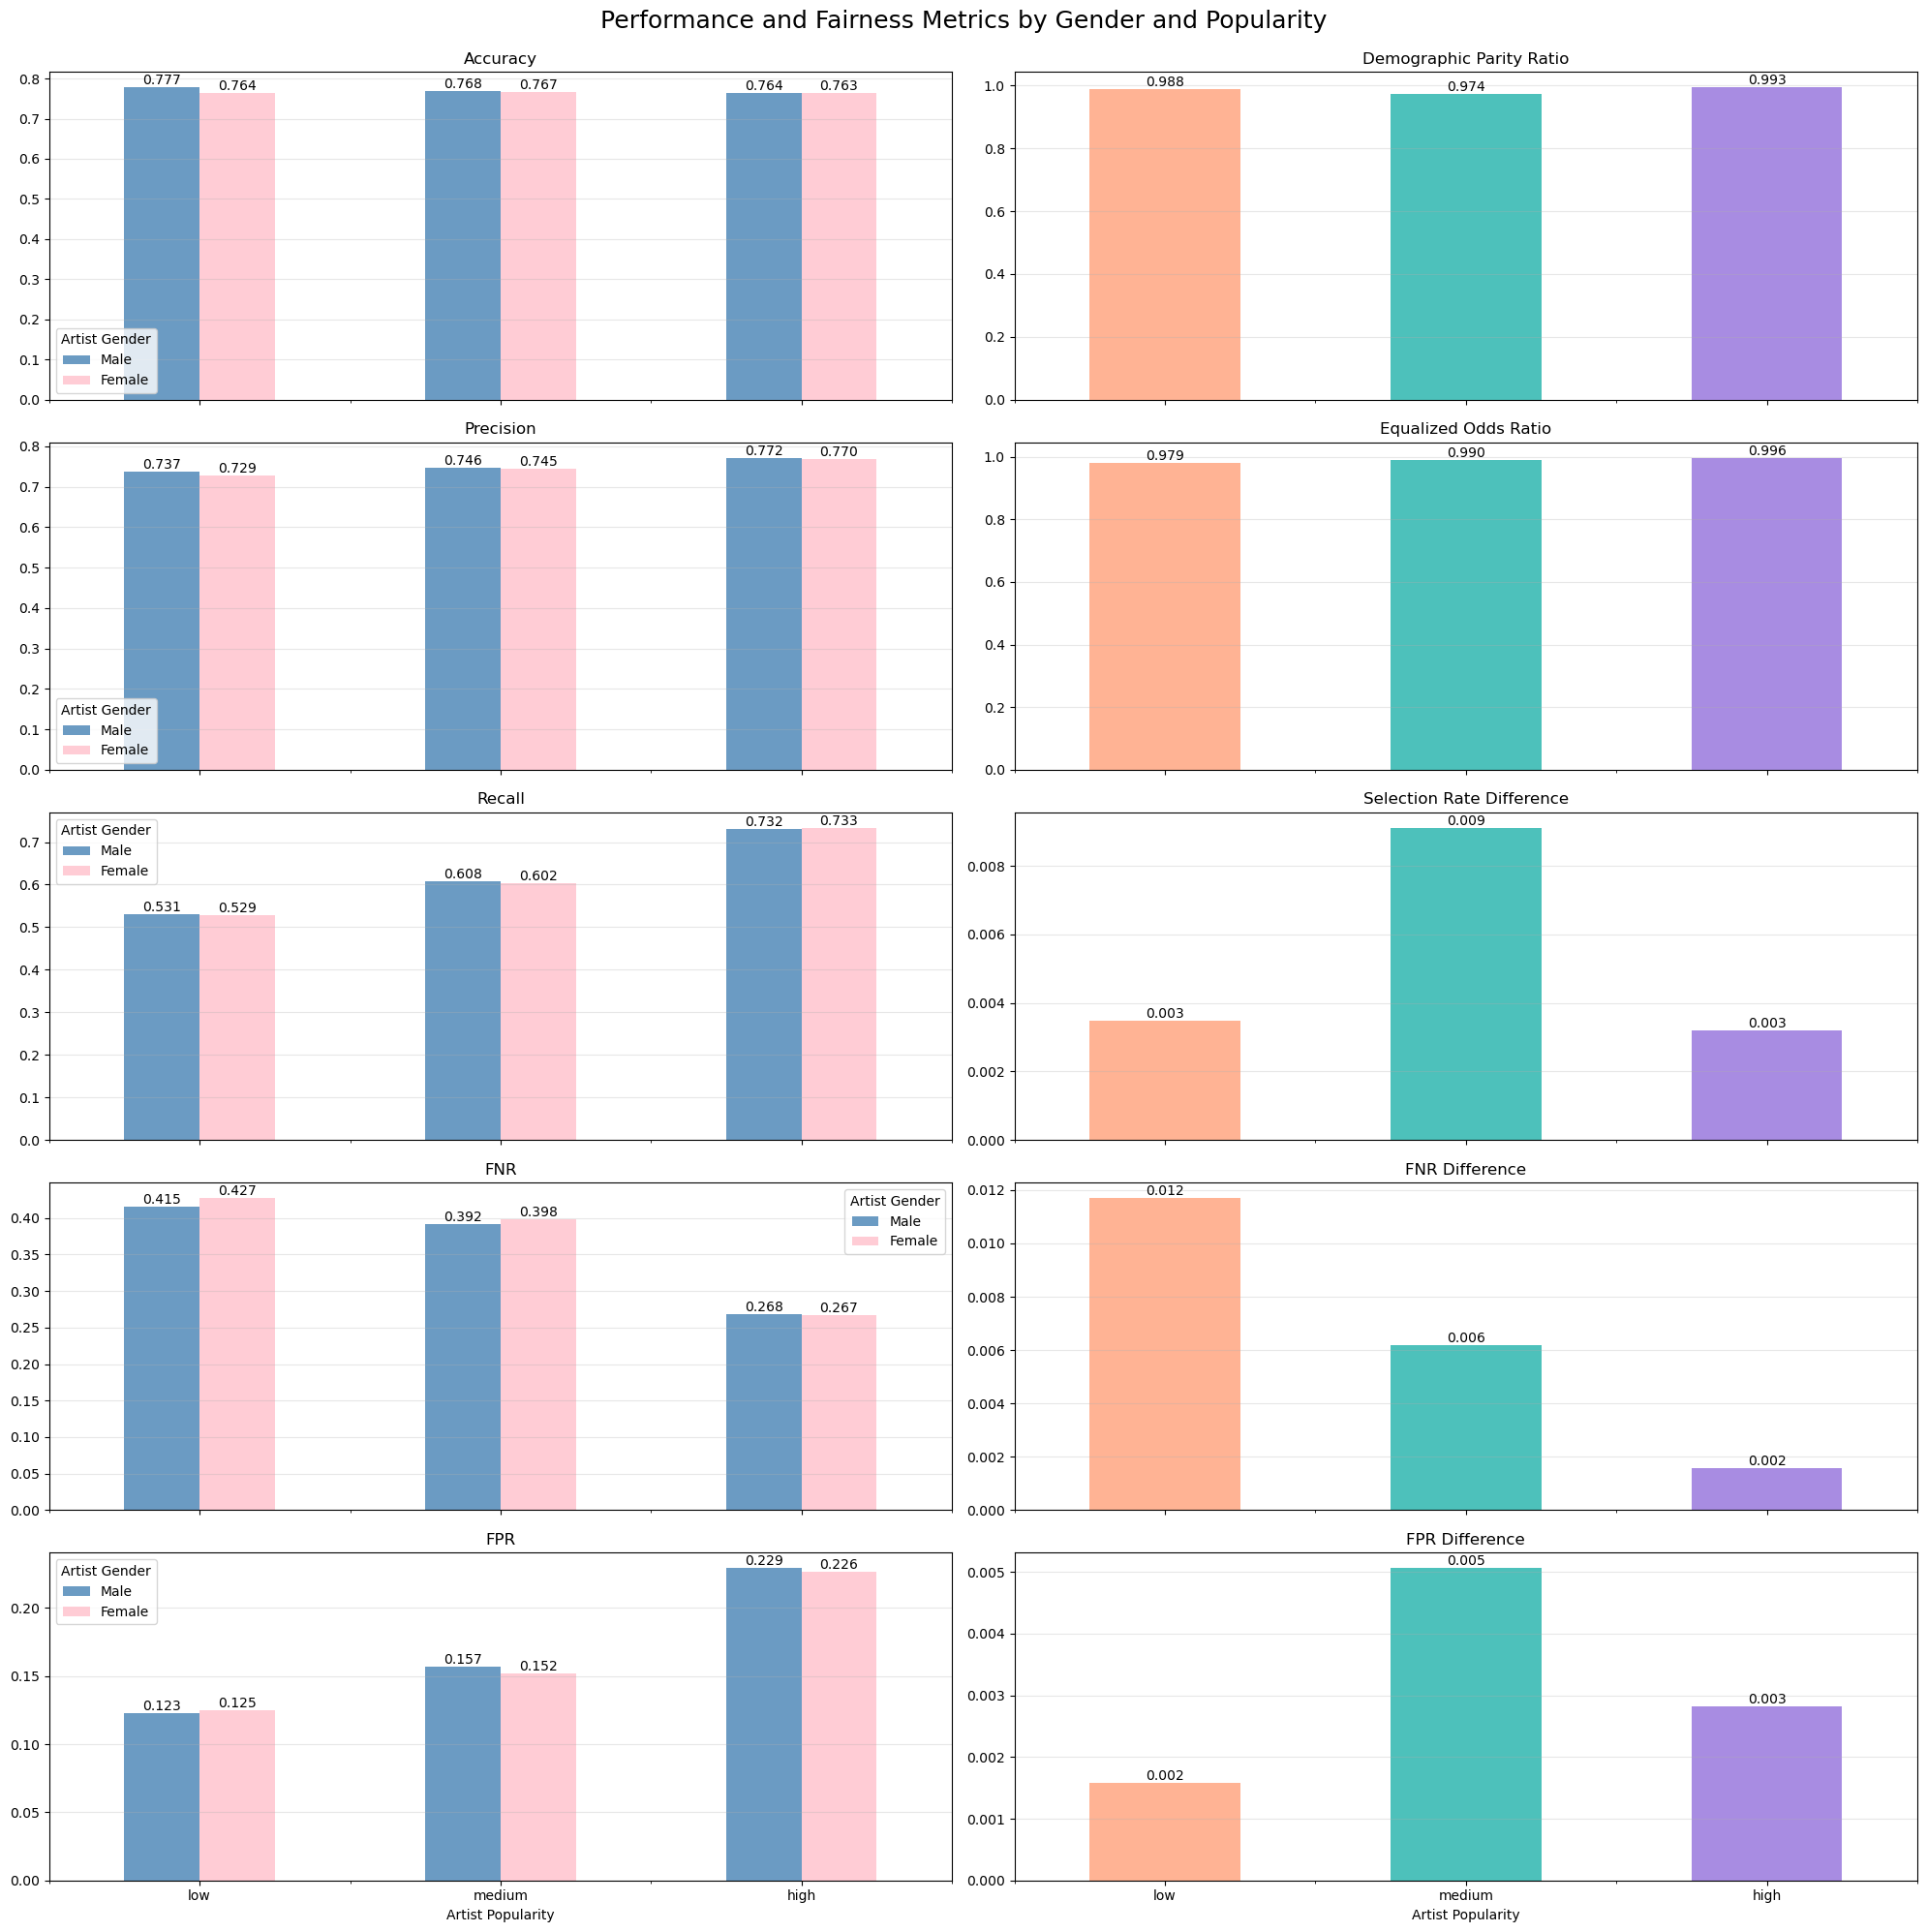

In [89]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20), sharex=True)

gender_colors = {'Male': 'steelblue', 'Female': 'pink'}
popularity_colors = {'low': '#FFA07A', 'medium': '#20B2AA', 'high': '#9370DB'}

for ax, metric in zip(axes[:,0], ['Accuracy', 'Precision', 'Recall', 'FNR', 'FPR']):
    artist_metrics_mean[metric].unstack('artist_gender').plot(kind='bar', ax=ax, color=gender_colors, alpha=0.8)
    ax.set_title(metric)
    ax.legend(title='Artist Gender')
    ax.grid(True, alpha=0.3, axis='y')

    for p in ax.patches:
        ax.text(
            x=p.get_x() + p.get_width() / 2,  # center of the bar
            y=p.get_height(),                 # height of the bar
            s=f'{p.get_height():.3f}',        # format value
            ha='center', va='bottom'          # align text
        )

for ax, metric in zip(axes[:,1], ['Demographic Parity Ratio', 'Equalized Odds Ratio', 'Selection Rate Difference', 'FNR Difference', 'FPR Difference']):
    fairness_metrics_df[metric].plot(
        kind='bar',
        ax=ax,
        alpha=0.8,
        color=[popularity_colors[pop] for pop in fairness_metrics_df.index]
    )
    ax.set_title(metric)
    ax.grid(True, alpha=0.3, axis='y')

    for p in ax.patches:
        ax.text(
            x=p.get_x() + p.get_width() / 2,  # center of the bar
            y=p.get_height(),                 # height of the bar
            s=f'{p.get_height():.3f}',        # format value
            ha='center', va='bottom'          # align text
        )

axes[4][0].tick_params(axis='x', rotation=0)
axes[4][1].tick_params(axis='x', rotation=0)
axes[4][0].set_xlabel('Artist Popularity')
axes[4][1].set_xlabel('Artist Popularity')

fig.suptitle('Performance and Fairness Metrics by Gender and Popularity', fontsize=18, y=0.995)
plt.tight_layout()
plt.show()